In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

In [3]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [5]:
np.random.seed(100)

In [6]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
    
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
 

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [7]:
print(y_train[0])
print(y_test.shape)
print(y_val.shape)

41
(12630,)
(4410,)


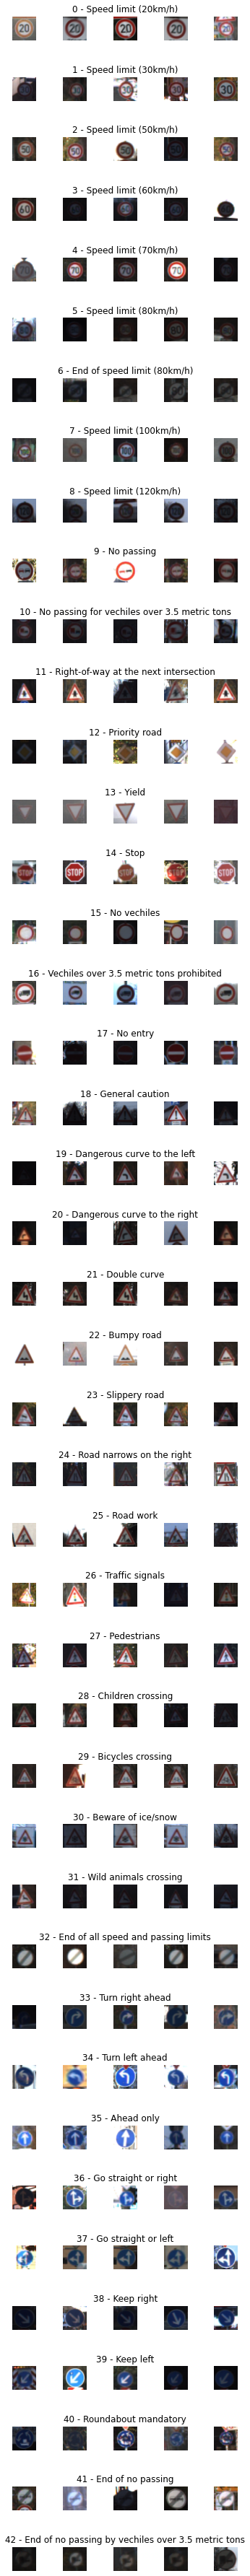

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


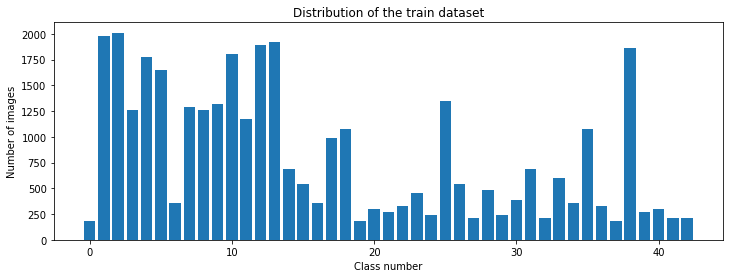

In [9]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


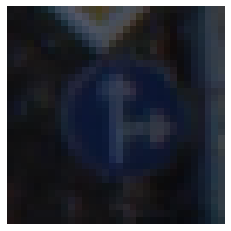

In [10]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)


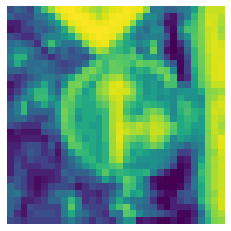

In [11]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [12]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


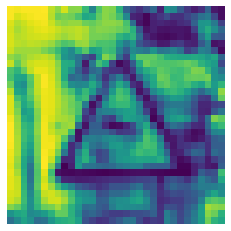

In [13]:
X_train_up = X_train
X_test_up = X_test
X_val_up = X_val

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [14]:
print(X_train.shape[0])

34799


In [15]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


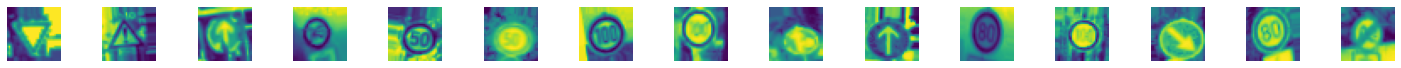

In [16]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [17]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [24]:
from tensorflow.keras.models import load_model
model=load_model("LeNet.h5")

In [22]:
 def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [18]:
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            epochs=15,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
696/696 [==============================] - 51s 31ms/step - loss: 2.5959 - accuracy: 0.2922 - val_loss: 0.3451 - val_accuracy: 0.8986
Epoch 2/15
696/696 [==============================] - 20s 29ms/step - loss: 0.7068 - accuracy: 0.7797 - val_loss: 0.2168 - val_accuracy: 0.9302
Epoch 3/15
696/696 [==============================] - 21s 30ms/step - loss: 0.3981 - accuracy: 0.8792 - val_loss: 0.1674 - val_accuracy: 0.9551
Epoch 4/15
696/696 [==============================] - 20s 29ms/step - loss: 0.2906 - accuracy: 0.9101 - val_loss: 0.1026 - val_accuracy: 0.9660
Epoch 5/15
696/696 [==============================] - 21s 30ms/step - loss: 0.2257 - accuracy: 0.9281 - val_loss: 0.0719 - val_accuracy: 0.9787
Epoch 6/15
696/696 [==============================] - 21s 30ms/step - loss: 0.2021 - accuracy: 0.9369 - val_loss: 0.0851 - val_accuracy: 0.9748
Epoch 7/15
696/696 [==============================] - 21s 30ms/step - loss: 0.1707 - accuracy: 0.9474 - val_loss: 0.0643 - val_accuracy:

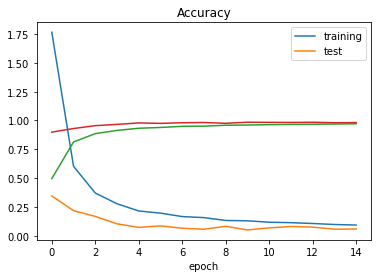

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.style.use('ggplot')

In [26]:
from time import time

start = time()
test_loss, test_acc = model.evaluate(X_test, y_test)
test_time = time() - start
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
print('Test time: ', test_time)

395/395 [==============================] - 2s 6ms/step - loss: 0.1270 - accuracy: 0.9679
Test accuracy: 0.9678543210029602
Test loss: 0.1269809454679489
Test time:  2.3638486862182617


In [ ]:
import os
model.save("LeNet.h5")

In [27]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

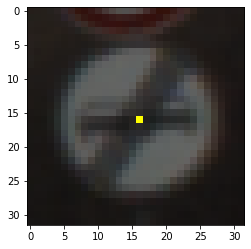

In [28]:
# checking if pertub_image is working correctly
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, X_train_up[20])[0]
plt.imshow(image_perturbed)

In [29]:
def evaluate_models(models, x_test, y_test):
    correct_imgs = []
    network_stats = []
    print('Evaluating', models.name)
    predictions = models.predict(x_test)
    # print(predictions)
    # print(predictions.shape)
    correct = [[models.name, i, label, np.max(pred), pred]
               for i, (label, pred)
               in enumerate(zip(y_test, predictions))
               if np.argmax(label) == np.argmax(pred)]
    print(correct)
    accuracy = len(correct) / len(x_test)
    correct_imgs += correct
    network_stats += [[models.name, accuracy, models.count_params()]]
    return [network_stats, correct_imgs], predictions

In [30]:
import pandas as pd
network_stats, predictions = evaluate_models(model, X_test, y_test)
correct_imgs = network_stats[1]
network_stats = network_stats[0]
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats
# correct_imgs

Evaluating sequential


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,name,accuracy,param_count
0,sequential,0.967854,378023


In [31]:
correct_imgs

,name,img,label,confidence,pred
0,sequential,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.999567,"[1.2589805e-16, 2.930261e-13, 3.2376034e-15, 1..."
1,sequential,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[3.9644465e-09, 1.0, 3.0283953e-10, 2.5418924e..."
2,sequential,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[2.816379e-26, 2.469175e-24, 7.2993726e-24, 1...."
3,sequential,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[3.8637534e-22, 6.238186e-13, 1.6662877e-13, 9..."
4,sequential,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[0.0, 9.921023e-35, 4.5586965e-37, 1.7284442e-..."
...,...,...,...,...,...
12219,sequential,12625,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[0.0, 3.923107e-27, 1.0953466e-25, 3.0270745e-..."
12220,sequential,12626,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[3.037641e-28, 7.978723e-15, 5.772519e-12, 2.5..."
12221,sequential,12627,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.589601,"[6.442816e-05, 0.13316484, 0.0024830743, 0.011..."
12222,sequential,12628,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1.000000,"[1.2379422e-16, 6.31681e-10, 2.705411e-12, 6.9..."


In [32]:
"""
A slight modification to Scipy's implementation of differential evolution. To speed up predictions, the entire parameters array is passed to `self.func`, where a neural network model can batch its computations and execute in parallel. Search for `CHANGES` to find all code changes.
Dan Kondratyuk 2018
Original code adapted from
https://github.com/scipy/scipy/blob/70e61dee181de23fdd8d893eaa9491100e2218d7/scipy/optimize/_differentialevolution.py
----------
differential_evolution: The differential evolution global optimization algorithm
Added by Andrew Nelson 2014
"""
from __future__ import division, print_function, absolute_import
import numpy as np
from scipy.optimize import OptimizeResult, minimize
from scipy.optimize.optimize import _status_message
from scipy._lib._util import check_random_state
from scipy._lib.six import xrange, string_types
import warnings


__all__ = ['differential_evolution']

_MACHEPS = np.finfo(np.float64).eps


def differential_evolution(func, bounds, args=(), strategy='best1bin',
                           maxiter=1000, popsize=15, tol=0.01,
                           mutation=(0.5, 1), recombination=0.7, seed=None,
                           callback=None, disp=False, polish=True,
                           init='latinhypercube', atol=0):
    """Finds the global minimum of a multivariate function.
    Differential Evolution is stochastic in nature (does not use gradient
    methods) to find the minimium, and can search large areas of candidate
    space, but often requires larger numbers of function evaluations than
    conventional gradient based techniques.
    The algorithm is due to Storn and Price [1]_.
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'.
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        ``U[min, max)``. Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.RandomState` singleton is used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with seed.
        If `seed` is already a `np.random.RandomState instance`, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True (default), then `scipy.optimize.minimize` with the `L-BFGS-B`
        method is used to polish the best population member at the end, which
        can improve the minimization slightly.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population subset could be used,
        for example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a `OptimizeResult` object.
        Important attributes are: ``x`` the solution array, ``success`` a
        Boolean flag indicating if the optimizer exited successfully and
        ``message`` which describes the cause of the termination. See
        `OptimizeResult` for a description of other attributes.  If `polish`
        was employed, and a lower minimum was obtained by the polishing, then
        OptimizeResult also contains the ``jac`` attribute.
    Notes
    -----
    Differential evolution is a stochastic population based method that is
    useful for global optimization problems. At each pass through the population
    the algorithm mutates each candidate solution by mixing with other candidate
    solutions to create a trial candidate. There are several strategies [2]_ for
    creating trial candidates, which suit some problems more than others. The
    'best1bin' strategy is a good starting point for many systems. In this
    strategy two members of the population are randomly chosen. Their difference
    is used to mutate the best member (the `best` in `best1bin`), :math:`b_0`,
    so far:
    .. math::
        b' = b_0 + mutation * (population[rand0] - population[rand1])
    A trial vector is then constructed. Starting with a randomly chosen 'i'th
    parameter the trial is sequentially filled (in modulo) with parameters from
    `b'` or the original candidate. The choice of whether to use `b'` or the
    original candidate is made with a binomial distribution (the 'bin' in
    'best1bin') - a random number in [0, 1) is generated.  If this number is
    less than the `recombination` constant then the parameter is loaded from
    `b'`, otherwise it is loaded from the original candidate.  The final
    parameter is always loaded from `b'`.  Once the trial candidate is built
    its fitness is assessed. If the trial is better than the original candidate
    then it takes its place. If it is also better than the best overall
    candidate it also replaces that.
    To improve your chances of finding a global minimum use higher `popsize`
    values, with higher `mutation` and (dithering), but lower `recombination`
    values. This has the effect of widening the search radius, but slowing
    convergence.
    .. versionadded:: 0.15.0
    Examples
    --------
    Let us consider the problem of minimizing the Rosenbrock function. This
    function is implemented in `rosen` in `scipy.optimize`.
    >>> from scipy.optimize import rosen, differential_evolution
    >>> bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]
    >>> result = differential_evolution(rosen, bounds)
    >>> result.x, result.fun
    (array([1., 1., 1., 1., 1.]), 1.9216496320061384e-19)
    Next find the minimum of the Ackley function
    (http://en.wikipedia.org/wiki/Test_functions_for_optimization).
    >>> from scipy.optimize import differential_evolution
    >>> import numpy as np
    >>> def ackley(x):
    ...     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    ...     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    ...     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
    >>> bounds = [(-5, 5), (-5, 5)]
    >>> result = differential_evolution(ackley, bounds)
    >>> result.x, result.fun
    (array([ 0.,  0.]), 4.4408920985006262e-16)
    References
    ----------
    .. [1] Storn, R and Price, K, Differential Evolution - a Simple and
           Efficient Heuristic for Global Optimization over Continuous Spaces,
           Journal of Global Optimization, 1997, 11, 341 - 359.
    .. [2] http://www1.icsi.berkeley.edu/~storn/code.html
    .. [3] http://en.wikipedia.org/wiki/Differential_evolution
    """

    solver = DifferentialEvolutionSolver(func, bounds, args=args,
                                         strategy=strategy, maxiter=maxiter,
                                         popsize=popsize, tol=tol,
                                         mutation=mutation,
                                         recombination=recombination,
                                         seed=seed, polish=polish,
                                         callback=callback,
                                         disp=disp, init=init, atol=atol)
    return solver.solve()


class DifferentialEvolutionSolver(object):

    """This class implements the differential evolution solver
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        U[min, max). Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.random.RandomState` singleton is
        used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with `seed`.
        If `seed` is already a `np.random.RandomState` instance, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True, then `scipy.optimize.minimize` with the `L-BFGS-B` method
        is used to polish the best population member at the end. This requires
        a few more function evaluations.
    maxfun : int, optional
        Set the maximum number of function evaluations. However, it probably
        makes more sense to set `maxiter` instead.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population could be used, for
        example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    """

    # Dispatch of mutation strategy method (binomial or exponential).
    _binomial = {'best1bin': '_best1',
                 'randtobest1bin': '_randtobest1',
                 'currenttobest1bin': '_currenttobest1',
                 'best2bin': '_best2',
                 'rand2bin': '_rand2',
                 'rand1bin': '_rand1'}
    _exponential = {'best1exp': '_best1',
                    'rand1exp': '_rand1',
                    'randtobest1exp': '_randtobest1',
                    'currenttobest1exp': '_currenttobest1',
                    'best2exp': '_best2',
                    'rand2exp': '_rand2'}

    __init_error_msg = ("The population initialization method must be one of "
                        "'latinhypercube' or 'random', or an array of shape "
                        "(M, N) where N is the number of parameters and M>5")

    def __init__(self, func, bounds, args=(),
                 strategy='best1bin', maxiter=1000, popsize=15,
                 tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None,
                 maxfun=np.inf, callback=None, disp=False, polish=True,
                 init='latinhypercube', atol=0):

        if strategy in self._binomial:
            self.mutation_func = getattr(self, self._binomial[strategy])
        elif strategy in self._exponential:
            self.mutation_func = getattr(self, self._exponential[strategy])
        else:
            raise ValueError("Please select a valid mutation strategy")
        self.strategy = strategy

        self.callback = callback
        self.polish = polish

        # relative and absolute tolerances for convergence
        self.tol, self.atol = tol, atol

        # Mutation constant should be in [0, 2). If specified as a sequence
        # then dithering is performed.
        self.scale = mutation
        if (not np.all(np.isfinite(mutation)) or
                np.any(np.array(mutation) >= 2) or
                np.any(np.array(mutation) < 0)):
            raise ValueError('The mutation constant must be a float in '
                             'U[0, 2), or specified as a tuple(min, max)'
                             ' where min < max and min, max are in U[0, 2).')

        self.dither = None
        if hasattr(mutation, '__iter__') and len(mutation) > 1:
            self.dither = [mutation[0], mutation[1]]
            self.dither.sort()

        self.cross_over_probability = recombination

        self.func = func
        self.args = args

        # convert tuple of lower and upper bounds to limits
        # [(low_0, high_0), ..., (low_n, high_n]
        #     -> [[low_0, ..., low_n], [high_0, ..., high_n]]
        self.limits = np.array(bounds, dtype='float').T
        if (np.size(self.limits, 0) != 2 or not
                np.all(np.isfinite(self.limits))):
            raise ValueError('bounds should be a sequence containing '
                             'real valued (min, max) pairs for each value'
                             ' in x')

        if maxiter is None:  # the default used to be None
            maxiter = 1000
        self.maxiter = maxiter
        if maxfun is None:  # the default used to be None
            maxfun = np.inf
        self.maxfun = maxfun

        # population is scaled to between [0, 1].
        # We have to scale between parameter <-> population
        # save these arguments for _scale_parameter and
        # _unscale_parameter. This is an optimization
        self.__scale_arg1 = 0.5 * (self.limits[0] + self.limits[1])
        self.__scale_arg2 = np.fabs(self.limits[0] - self.limits[1])

        self.parameter_count = np.size(self.limits, 1)

        self.random_number_generator = check_random_state(seed)

        # default population initialization is a latin hypercube design, but
        # there are other population initializations possible.
        # the minimum is 5 because 'best2bin' requires a population that's at
        # least 5 long
        self.num_population_members = max(5, popsize * self.parameter_count)

        self.population_shape = (self.num_population_members,
                                 self.parameter_count)

        self._nfev = 0
        if isinstance(init, string_types):
            if init == 'latinhypercube':
                self.init_population_lhs()
            elif init == 'random':
                self.init_population_random()
            else:
                raise ValueError(self.__init_error_msg)
        else:
            self.init_population_array(init)

        self.disp = disp

    def init_population_lhs(self):
        """
        Initializes the population with Latin Hypercube Sampling.
        Latin Hypercube Sampling ensures that each parameter is uniformly
        sampled over its range.
        """
        rng = self.random_number_generator

        # Each parameter range needs to be sampled uniformly. The scaled
        # parameter range ([0, 1)) needs to be split into
        # `self.num_population_members` segments, each of which has the following
        # size:
        segsize = 1.0 / self.num_population_members

        # Within each segment we sample from a uniform random distribution.
        # We need to do this sampling for each parameter.
        samples = (segsize * rng.random_sample(self.population_shape)

        # Offset each segment to cover the entire parameter range [0, 1)
                   + np.linspace(0., 1., self.num_population_members,
                                 endpoint=False)[:, np.newaxis])

        # Create an array for population of candidate solutions.
        self.population = np.zeros_like(samples)

        # Initialize population of candidate solutions by permutation of the
        # random samples.
        for j in range(self.parameter_count):
            order = rng.permutation(range(self.num_population_members))
            self.population[:, j] = samples[order, j]

        # reset population energies
        self.population_energies = (np.ones(self.num_population_members) *
                                    np.inf)

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_random(self):
        """
        Initialises the population at random.  This type of initialization
        can possess clustering, Latin Hypercube sampling is generally better.
        """
        rng = self.random_number_generator
        self.population = rng.random_sample(self.population_shape)

        # reset population energies
        self.population_energies = (np.ones(self.num_population_members) *
                                    np.inf)

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_array(self, init):
        """
        Initialises the population with a user specified population.
        Parameters
        ----------
        init : np.ndarray
            Array specifying subset of the initial population. The array should
            have shape (M, len(x)), where len(x) is the number of parameters.
            The population is clipped to the lower and upper `bounds`.
        """
        # make sure you're using a float array
        popn = np.asfarray(init)

        if (np.size(popn, 0) < 5 or
                popn.shape[1] != self.parameter_count or
                len(popn.shape) != 2):
            raise ValueError("The population supplied needs to have shape"
                             " (M, len(x)), where M > 4.")

        # scale values and clip to bounds, assigning to population
        self.population = np.clip(self._unscale_parameters(popn), 0, 1)

        self.num_population_members = np.size(self.population, 0)

        self.population_shape = (self.num_population_members,
                                 self.parameter_count)

        # reset population energies
        self.population_energies = (np.ones(self.num_population_members) *
                                    np.inf)

        # reset number of function evaluations counter
        self._nfev = 0

    @property
    def x(self):
        """
        The best solution from the solver
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        """
        return self._scale_parameters(self.population[0])

    @property
    def convergence(self):
        """
        The standard deviation of the population energies divided by their
        mean.
        """
        return (np.std(self.population_energies) /
                np.abs(np.mean(self.population_energies) + _MACHEPS))

    def solve(self):
        """
        Runs the DifferentialEvolutionSolver.
        Returns
        -------
        res : OptimizeResult
            The optimization result represented as a ``OptimizeResult`` object.
            Important attributes are: ``x`` the solution array, ``success`` a
            Boolean flag indicating if the optimizer exited successfully and
            ``message`` which describes the cause of the termination. See
            `OptimizeResult` for a description of other attributes.  If `polish`
            was employed, and a lower minimum was obtained by the polishing,
            then OptimizeResult also contains the ``jac`` attribute.
        """
        nit, warning_flag = 0, False
        status_message = _status_message['success']

        # The population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies.
        # Although this is also done in the evolve generator it's possible
        # that someone can set maxiter=0, at which point we still want the
        # initial energies to be calculated (the following loop isn't run).
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        # do the optimisation.
        for nit in xrange(1, self.maxiter + 1):
            # evolve the population by a generation
            try:
                next(self)
            except StopIteration:
                warning_flag = True
                status_message = _status_message['maxfev']
                break

            if self.disp:
                print("differential_evolution step %d: f(x)= %g"
                      % (nit,
                         self.population_energies[0]))

            # should the solver terminate?
            convergence = self.convergence

            if (self.callback and
                    self.callback(self._scale_parameters(self.population[0]),
                                  convergence=self.tol / convergence) is True):

                warning_flag = True
                status_message = ('callback function requested stop early '
                                  'by returning True')
                break

            intol = (np.std(self.population_energies) <=
                     self.atol +
                     self.tol * np.abs(np.mean(self.population_energies)))
            if warning_flag or intol:
                break

        else:
            status_message = _status_message['maxiter']
            warning_flag = True

        DE_result = OptimizeResult(
            x=self.x,
            fun=self.population_energies[0],
            nfev=self._nfev,
            nit=nit,
            message=status_message,
            success=(warning_flag is not True))

        if self.polish:
            result = minimize(self.func,
                              np.copy(DE_result.x),
                              method='L-BFGS-B',
                              bounds=self.limits.T,
                              args=self.args)

            self._nfev += result.nfev
            DE_result.nfev = self._nfev

            if result.fun < DE_result.fun:
                DE_result.fun = result.fun
                DE_result.x = result.x
                DE_result.jac = result.jac
                # to keep internal state consistent
                self.population_energies[0] = result.fun
                self.population[0] = self._unscale_parameters(result.x)

        return DE_result

    def _calculate_population_energies(self):
        """
        Calculate the energies of all the population members at the same time.
        Puts the best member in first place. Useful if the population has just
        been initialised.
        """

        ##############
        ## CHANGES: self.func operates on the entire parameters array
        ##############
        itersize = max(0, min(len(self.population), self.maxfun - self._nfev + 1))
        candidates = self.population[:itersize]
        parameters = np.array([self._scale_parameters(c) for c in candidates]) # TODO: can be vectorized
        energies = self.func(parameters, *self.args)
        self.population_energies = energies
        self._nfev += itersize

        ###############################

        # for index, candidate in enumerate(self.population):
        #     if self._nfev > self.maxfun:
        #         break

        #     parameters = self._scale_parameters(candidate)
        #     self.population_energies[index] = self.func(parameters,
        #                                                 *self.args)
        #     self._nfev += 1

        ##############
        ##############

        

        minval = np.argmin(self.population_energies)

        # put the lowest energy into the best solution position.
        lowest_energy = self.population_energies[minval]
        self.population_energies[minval] = self.population_energies[0]
        self.population_energies[0] = lowest_energy

        self.population[[0, minval], :] = self.population[[minval, 0], :]

    def __iter__(self):
        return self

    def __next__(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # the population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        if self.dither is not None:
            self.scale = (self.random_number_generator.rand()
                          * (self.dither[1] - self.dither[0]) + self.dither[0])

        ##############
        ## CHANGES: self.func operates on the entire parameters array
        ##############

        itersize = max(0, min(self.num_population_members, self.maxfun - self._nfev + 1))
        trials = np.array([self._mutate(c) for c in range(itersize)]) # TODO: can be vectorized
        for trial in trials: self._ensure_constraint(trial)
        parameters = np.array([self._scale_parameters(trial) for trial in trials])
        energies = self.func(parameters, *self.args)
        self._nfev += itersize

        for candidate,(energy,trial) in enumerate(zip(energies, trials)):
            # if the energy of the trial candidate is lower than the
            # original population member then replace it
            if energy < self.population_energies[candidate]:
                self.population[candidate] = trial
                self.population_energies[candidate] = energy

                # if the trial candidate also has a lower energy than the
                # best solution then replace that as well
                if energy < self.population_energies[0]:
                    self.population_energies[0] = energy
                    self.population[0] = trial

                    ################################################################

        # for candidate in range(self.num_population_members):
        #     if self._nfev > self.maxfun:
        #         raise StopIteration

        #     # create a trial solution
        #     trial = self._mutate(candidate)

        #     # ensuring that it's in the range [0, 1)
        #     self._ensure_constraint(trial)

        #     # scale from [0, 1) to the actual parameter value
        #     parameters = self._scale_parameters(trial)

        #     # determine the energy of the objective function
        #     energy = self.func(parameters, *self.args)
        #     self._nfev += 1

        #     # if the energy of the trial candidate is lower than the
        #     # original population member then replace it
        #     if energy < self.population_energies[candidate]:
        #         self.population[candidate] = trial
        #         self.population_energies[candidate] = energy

        #         # if the trial candidate also has a lower energy than the
        #         # best solution then replace that as well
        #         if energy < self.population_energies[0]:
        #             self.population_energies[0] = energy
        #             self.population[0] = trial

        ##############
        ##############

        return self.x, self.population_energies[0]

    def next(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # next() is required for compatibility with Python2.7.
        return self.__next__()

    def _scale_parameters(self, trial):
        """
        scale from a number between 0 and 1 to parameters.
        """
        return self.__scale_arg1 + (trial - 0.5) * self.__scale_arg2

    def _unscale_parameters(self, parameters):
        """
        scale from parameters to a number between 0 and 1.
        """
        return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5

    def _ensure_constraint(self, trial):
        """
        make sure the parameters lie between the limits
        """
        for index in np.where((trial < 0) | (trial > 1))[0]:
            trial[index] = self.random_number_generator.rand()

    def _mutate(self, candidate):
        """
        create a trial vector based on a mutation strategy
        """
        trial = np.copy(self.population[candidate])

        rng = self.random_number_generator

        fill_point = rng.randint(0, self.parameter_count)

        if self.strategy in ['currenttobest1exp', 'currenttobest1bin']:
            bprime = self.mutation_func(candidate,
                                        self._select_samples(candidate, 5))
        else:
            bprime = self.mutation_func(self._select_samples(candidate, 5))

        if self.strategy in self._binomial:
            crossovers = rng.rand(self.parameter_count)
            crossovers = crossovers < self.cross_over_probability
            # the last one is always from the bprime vector for binomial
            # If you fill in modulo with a loop you have to set the last one to
            # true. If you don't use a loop then you can have any random entry
            # be True.
            crossovers[fill_point] = True
            trial = np.where(crossovers, bprime, trial)
            return trial

        elif self.strategy in self._exponential:
            i = 0
            while (i < self.parameter_count and
                   rng.rand() < self.cross_over_probability):

                trial[fill_point] = bprime[fill_point]
                fill_point = (fill_point + 1) % self.parameter_count
                i += 1

            return trial

    def _best1(self, samples):
        """
        best1bin, best1exp
        """
        r0, r1 = samples[:2]
        return (self.population[0] + self.scale *
                (self.population[r0] - self.population[r1]))

    def _rand1(self, samples):
        """
        rand1bin, rand1exp
        """
        r0, r1, r2 = samples[:3]
        return (self.population[r0] + self.scale *
                (self.population[r1] - self.population[r2]))

    def _randtobest1(self, samples):
        """
        randtobest1bin, randtobest1exp
        """
        r0, r1, r2 = samples[:3]
        bprime = np.copy(self.population[r0])
        bprime += self.scale * (self.population[0] - bprime)
        bprime += self.scale * (self.population[r1] -
                                self.population[r2])
        return bprime

    def _currenttobest1(self, candidate, samples):
        """
        currenttobest1bin, currenttobest1exp
        """
        r0, r1 = samples[:2]
        bprime = (self.population[candidate] + self.scale * 
                  (self.population[0] - self.population[candidate] +
                   self.population[r0] - self.population[r1]))
        return bprime

    def _best2(self, samples):
        """
        best2bin, best2exp
        """
        r0, r1, r2, r3 = samples[:4]
        bprime = (self.population[0] + self.scale *
                  (self.population[r0] + self.population[r1] -
                   self.population[r2] - self.population[r3]))

        return bprime

    def _rand2(self, samples):
        """
        rand2bin, rand2exp
        """
        r0, r1, r2, r3, r4 = samples
        bprime = (self.population[r0] + self.scale *
                  (self.population[r1] + self.population[r2] -
                   self.population[r3] - self.population[r4]))

        return bprime

    def _select_samples(self, candidate, number_samples):
        """
        obtain random integers from range(self.num_population_members),
        without replacement.  You can't have the original candidate either.
        """
        idxs = list(range(self.num_population_members))
        idxs.remove(candidate)
        self.random_number_generator.shuffle(idxs)
        idxs = idxs[:number_samples]
        return idxs

In [33]:
# this is only for debugging above things
print(y_test)
print(y_test.shape)
print(predictions)
print(predictions.shape)
print(y_test[0])
print(predictions[0])
correct_imgs
# for i in enumerate(zip(y_test, predictions)):
#   print(i)
#   break
print(np.argmax(y_test[0]))
print(np.argmax(predictions[0]))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(12630, 43)
[[1.2589805e-16 2.9302610e-13 3.2376034e-15 ... 2.0155859e-07
  3.6730425e-14 1.6879341e-13]
 [3.9644465e-09 1.0000000e+00 3.0283953e-10 ... 1.0256252e-16
  2.9040602e-28 5.8097589e-18]
 [2.8163789e-26 2.4691751e-24 7.2993726e-24 ... 1.1705283e-23
  1.7367758e-34 1.3486863e-27]
 ...
 [6.4428161e-05 1.3316484e-01 2.4830743e-03 ... 3.0400523e-07
  1.4861911e-05 2.1402899e-03]
 [1.2379422e-16 6.3168099e-10 2.7054110e-12 ... 1.4177097e-11
  3.1790761e-27 6.7694975e-20]
 [2.0542686e-17 2.3035919e-13 2.1318820e-08 ... 1.0156489e-07
  3.2640193e-17 2.3112640e-12]]
(12630, 43)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.25898054e-16 2.93026101e-13 3.23760345e-15 1.38992268e-12
 1.34049122e-14 8.65689798e-10 5.06412809e-17 7.24401332e-07
 2

In [34]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])

true_class = np.where(y_test[image_id] == 1.)[0][0]
# print(np.where(true_class == 1.)[0][0])
# print(type(X_test))
# print(type(X_test[0]))
prior_confidence = model.predict( np.array( [X_test[384],] )  )[0][true_class]
# prior_confidence = model.predict(X_test[384])#[image_id] #[true_class]
print(prior_confidence)
# confidence = predict_classes(pixel, np.array( [X_test[384],]), true_class, model)[0]

# print('Confidence in true class', class_names[true_class], 'is', confidence)
# print('Prior confidence was', prior_confidence)


0.99999976


In [35]:
def img_processing(attack_image):
  attack_image = np.array(list(map(preprocess, attack_image)))
  attack_image = attack_image.reshape((attack_image.shape[0]), 32, 32, 1)
  return attack_image

In [36]:
def attack_success(x, img_id, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, X_test_up[img_id])
    attack_image = img_processing(attack_image)
    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if (#(targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

In [40]:
image_id = 541
pixel = np.array([15, 15, 185, 36, 215])

true_class = np.where(y_test[image_id] == 1.)[0][0]
print(true_class)
print(np.argmax(y_test[image_id]))
prior_confidence = model.predict(np.array( [X_test[image_id],] ))[0][true_class]
print(prior_confidence)
confidence = predict_classes(pixel, image_id, true_class, model)[0]
success = attack_success(pixel, image_id, true_class, model, targeted_attack=False, verbose=True)
print(confidence)
print('Prior confidence', prior_confidence)
print('Attack success:', success == True)

6
6
0.9999857
Confidence: 0.9999949
0.9999949
Prior confidence 0.9999857
Attack success: False


In [39]:
def predict_classes(xs, img_id, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    img = X_test_up[img_id]
    imgs_perturbed = img_processing(perturb_image(xs, img))

    predictions = model.predict(imgs_perturbed)[:,target_class]
    # print("prediction ::")
    # print(predictions)
    # print(model.predict(imgs_perturbed))
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [41]:
def attack(img_id, model, target=None, pixel_count=1, maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else (np.argmax(y_test[image_id]))
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, img_id, target_class, model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, img_id, target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul, recombination=1, atol=-2, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, X_test_up[img_id])
    plt.imshow(attack_image[0])
    attack_image = img_processing(attack_image)
    # prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = np.argmax(y_test[img_id])
    success = predicted_class != actual_class
    # success = attack_success(attack_result.x, img_id, target_class, model, targeted_attack, verbose)
    # cdiff = prior_probs[actual_class] - predicted_probs[actual_class]


    return [pixel_count, img_id, actual_class, predicted_class, success, predicted_probs, attack_result.x]

Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.99999964
Confidence: 0.9999993
Confidence: 0.9999993
Confidence: 0.9999993
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9999956
Confidence: 0.9969415
Confidence: 0.6890063
Confidence: 0.6890063
Confidence: 0.6890063
Confidence: 0.6890063
Confidence: 0.21105699
[1, 46, 3, 5, True, array([[1.0096463e-14, 1.4309798e-09, 3.2017098e-07, 2.1105699e-01,
        3.5740730e-16, 7.8894192e-01, 1.9944355e-11, 7.4614553e-07,
        3.4706118e-12, 2.2120779e-14, 6.4366820e-14, 2.2058128e-18,
        3.2480681e-15, 9.9666746e-20, 6.5336475e-17, 5.8502994e-11,
        8.7111888e-18, 3.7585953e-22, 5.4166527e-22, 9.2565136e-24,
        3.8171225e-18, 1.5953099e-18, 1.9524105e-16, 1.5241000e-22,
        6.0838695e-19, 6.7729840e-17, 5.4811532e-21, 8.5309493e-24,
        6.5733314e-14, 7.3529530e-11, 8.2618108e-13, 3.4603926e-12,
        5.7373072e-19, 6.4272609e-14

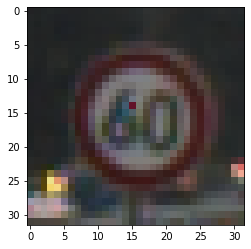

In [42]:
image_id = 46
pixels = 1 # Number of pixels to attack
plt.imshow(X_test_up[4])
results = attack(image_id, model, pixel_count=pixels, verbose=True)
print(results)

0            0
1            1
2            2
3            3
4            4
         ...  
12219    12625
12220    12626
12221    12627
12222    12628
12223    12629
Name: img, Length: 12224, dtype: int64
0
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:582: RuntimeWarning: divide by zero encountered in double_scalars


Streaming output truncated to the last 5000 lines.
7459
7460
7461
7462
7463
7464
7465
7466
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7526
7527
7528
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7572
7573
7574
7575
7576
7577
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7594
7595
7596
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7634
7635
7636
7637
7638
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657

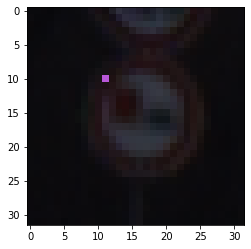

In [44]:
print(correct_imgs.img)
results = []
for i in correct_imgs.img:
  result = attack(i, model, pixel_count=1, verbose=False)
  print(result[1])
  results.append([result[1],result[2],result[3],result[4]])

# def attack_all():


In [52]:
import csv

with open("temp.csv", "w", newline="") as f:
   writer = csv.writer(f)
   writer.writerows(results)

print(results)

[[0, 16, 16, False], [1, 1, 1, False], [2, 38, 38, False], [3, 33, 33, False], [4, 11, 11, False], [5, 38, 38, False], [6, 18, 18, False], [7, 12, 12, False], [8, 25, 25, False], [9, 35, 35, False], [10, 12, 12, False], [11, 7, 7, False], [12, 23, 23, False], [13, 7, 7, False], [14, 4, 4, False], [15, 9, 9, False], [16, 21, 21, False], [17, 20, 20, False], [18, 27, 27, False], [19, 38, 38, False], [20, 4, 4, False], [21, 33, 33, False], [22, 9, 9, False], [23, 3, 3, False], [24, 1, 1, False], [25, 11, 11, False], [26, 13, 13, False], [27, 10, 10, False], [28, 9, 9, False], [29, 11, 11, False], [30, 5, 2, True], [31, 17, 17, False], [32, 34, 34, False], [33, 23, 23, False], [34, 2, 2, False], [35, 17, 17, False], [36, 3, 2, True], [37, 12, 12, False], [38, 16, 16, False], [39, 8, 8, False], [40, 7, 7, False], [41, 30, 30, False], [42, 18, 18, False], [43, 12, 12, False], [44, 24, 24, False], [45, 25, 25, False], [46, 3, 5, True], [47, 10, 10, False], [48, 18, 18, False], [49, 8, 8, Fals

In [55]:
j = 0
for i in results:
  if i[3] == True:
    j = j + 1

print(j)

print(j/12629)

460
0.03642410325441444
